# Flash Attention & Standard Attention Mechanism

Transformers are slow and data hungry on long sequences due to time and memory complexity of self-attention, which is O(seq_len^2). There are another attention methods attempting to alleviate this issue by trading off model quality by focusing on FLOP reduction. In this study, Flash Attention (FA) is proposed. FA is an IO-aware exact attention algorithm that focuses on overheadsfrom memory access (IO). It uses tiling (with block sizes) to reduce reduce the number of memory reads/writes between GPU high bandwidth memory (HBM) and GPU on-chip SRAM.

This fewer accesses to memory is accomplished by:
* computing the softmax reduction without access to the whole input
* not storing the large intermediate attention matrix for the backward pass

Future Direction: compiling to cuda, io-aware deep learning, multi-gpu io-aware methods.

Paper: https://arxiv.org/pdf/2205.14135.pdf

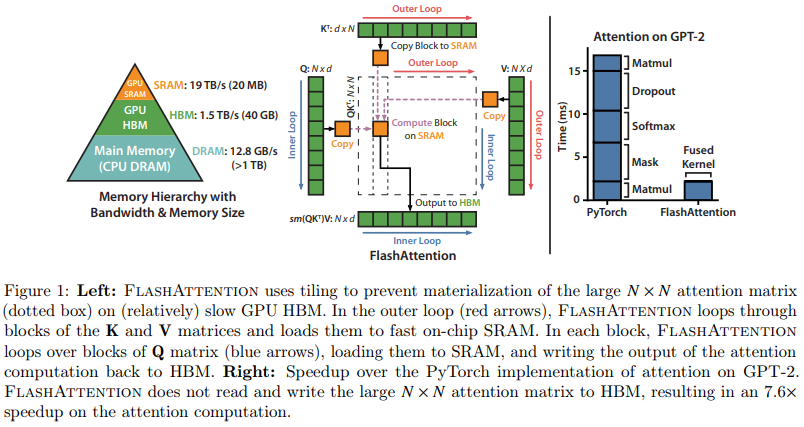

In [1]:
import torch
import torch.nn as nn
import numpy as np

import time

In [2]:
%%capture

!pip install einops
import einops

# Attention Mechanism

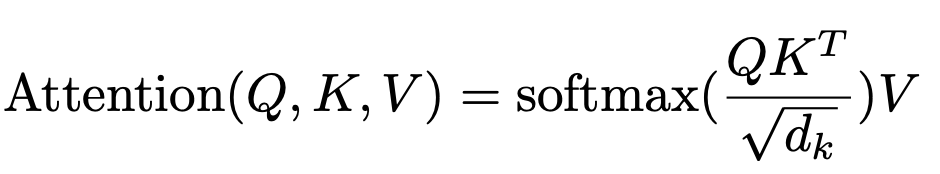

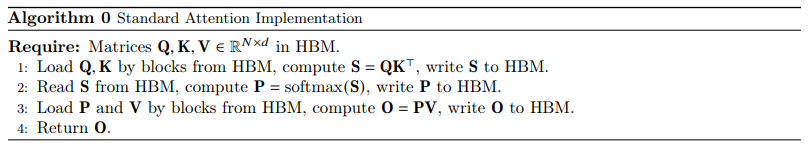

In [3]:
class Constants:
  BLOCK_SIZE = 1024
  NEG_INF = -1e10
  POS_INF = 1e10
  EPSILON = 1e-10

  GREEN = "\033[92m"
  RED = "\033[91m"

consts = Constants()

In [4]:
class ClassicalAttention:
  def __init__(self, Q, K, V, mask=None):
    self.Q = Q
    self.K = K
    self.V = V
    self.mask = mask

  def softmax(self, x, dim:int=None):
    exp_x = np.exp(x)
    sum_exp_x = np.sum(exp_x, axis=dim, keepdims=True)
    return exp_x / sum_exp_x

  def attn(self):
    dk = 1 / np.sqrt(self.Q.shape[-1])
    Q = self.Q * dk
    QKt = Q @ self.K.transpose(-2, -1)
    key_mask = np.expand_dims(np.expand_dims(self.mask, axis=1), axis=1)
    QKt = np.where(key_mask > 0, QKt, consts.NEG_INF)
    attn = self.softmax(QKt, dim=-1)
    return torch.tensor(attn) @ self.V

In [5]:
# https://github.com/shreyansh26/FlashAttention-PyTorch/blob/master/flash_attention.py
def normal_attention(Q, K, V, mask=None):
    from einops import rearrange
    scale = 1 / np.sqrt(Q.shape[-1])
    Q = Q * scale
    QKt = torch.einsum('... i d, ... j d -> ... i j', Q, K)

    key_mask = rearrange(mask, 'b j -> b 1 1 j')
    QKt = torch.where(key_mask > 0, QKt, consts.NEG_INF)

    attn = nn.functional.softmax(QKt, dim=-1)
    return attn @ V

# Flash Attention Mechanism

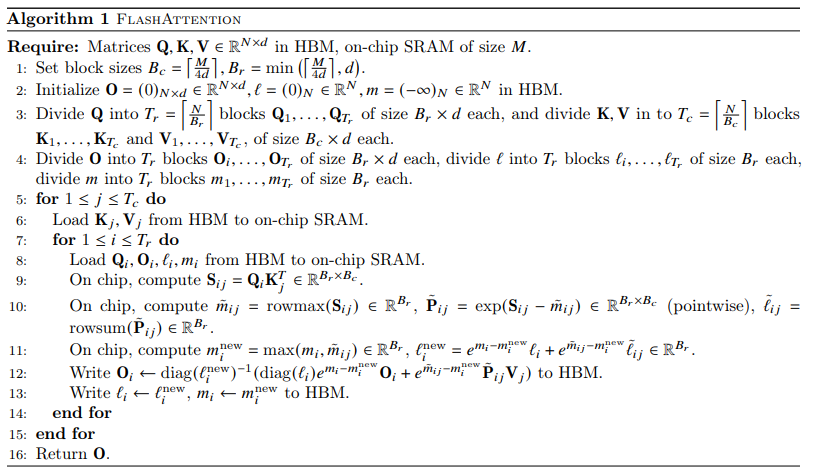

In [6]:
class FlashAttention:
  def __init__(self, Q, K, V, mask):
    self.Q, self.K, self.V = Q, K, V

    self.O = torch.zeros_like(Q)
    self.l = torch.zeros(Q.shape[:-1])[..., None] # [..., None] adds new axis
    self.m = torch.ones(Q.shape[:-1])[..., None] * consts.NEG_INF

    self.Q_BLOCK_SIZE = min(consts.BLOCK_SIZE, Q.shape[-1]) # Br
    self.KV_BLOCK_SIZE = consts.BLOCK_SIZE # Bc

    self.Q_BLOCKS = torch.split(Q, self.Q_BLOCK_SIZE, dim=2)
    self.K_BLOCKS = torch.split(K, self.KV_BLOCK_SIZE, dim=2)
    self.V_BLOCKS = torch.split(V, self.KV_BLOCK_SIZE, dim=2)

    self.MASK_BLOCKS = list(torch.split(mask, self.KV_BLOCK_SIZE, dim=1))

    self.Tr = len(self.Q_BLOCKS) # N/Br
    self.Tc = len(self.K_BLOCKS) # N/Bc

    self.O_BLOCKS = list(torch.split(self.O, self.Q_BLOCK_SIZE, dim=2))
    self.l_BLOCKS = list(torch.split(self.l, self.Q_BLOCK_SIZE, dim=2))
    self.m_BLOCKS = list(torch.split(self.m, self.Q_BLOCK_SIZE, dim=2))

  def flash_attention(self):
    for j in range(self.Tc):
      Kj = self.K_BLOCKS[j]
      Vj = self.V_BLOCKS[j]
      maskj = self.MASK_BLOCKS[j]
      for i in range(self.Tr):
        Qi = self.Q_BLOCKS[i]
        Oi = self.O_BLOCKS[i]
        li = self.l_BLOCKS[i]
        mi = self.m_BLOCKS[i]

        scale = 1 / np.sqrt(self.Q.shape[-1])
        Qi_scaled = Qi * scale

        Sij = torch.einsum('... i d, ... j d -> ... i j', Qi_scaled, Kj)

        maskj_tmp = maskj.unsqueeze(1).unsqueeze(1)
        Sij = torch.where(maskj_tmp > 0, Sij, consts.NEG_INF)

        m_block_ij, _ = torch.max(Sij, dim=-1, keepdims=True)

        Pij = torch.exp(Sij - m_block_ij)
        Pij = torch.where(maskj_tmp > 0, Pij, 0.)

        l_block_ij = torch.sum(Pij, dim=-1, keepdims=True) + consts.EPSILON

        P_ij_Vj = torch.einsum('... i j, ... j d -> ... i d', Pij, Vj)

        mi_new = torch.maximum(m_block_ij, mi)
        li_new = torch.exp(mi - mi_new) * li + torch.exp(m_block_ij - mi_new) * l_block_ij

        self.O_BLOCKS[i] = (li/li_new) * torch.exp(mi - mi_new) * Oi + (torch.exp(m_block_ij - mi_new) / li_new) * P_ij_Vj
        self.l_BLOCKS[i] = li_new
        self.m_BLOCKS[i] = mi_new

    O = torch.cat(self.O_BLOCKS, dim=2)
    l = torch.cat(self.l_BLOCKS, dim=2)
    m = torch.cat(self.m_BLOCKS, dim=2)

    return O, l, m

In [7]:
# https://github.com/shreyansh26/FlashAttention-PyTorch/blob/master/flash_attention.py
def flash_attention_forward(Q, K, V, mask=None):
    from einops import rearrange
    O = torch.zeros_like(Q, requires_grad=True)
    l = torch.zeros(Q.shape[:-1])[...,None]
    m = torch.ones(Q.shape[:-1])[...,None] * consts.NEG_INF

    Q_BLOCK_SIZE = min(consts.BLOCK_SIZE, Q.shape[-1])
    KV_BLOCK_SIZE = consts.BLOCK_SIZE

    Q_BLOCKS = torch.split(Q, Q_BLOCK_SIZE, dim=2)
    K_BLOCKS = torch.split(K, KV_BLOCK_SIZE, dim=2)
    V_BLOCKS = torch.split(V, KV_BLOCK_SIZE, dim=2)
    mask_BLOCKS = list(torch.split(mask, KV_BLOCK_SIZE, dim=1))

    Tr = len(Q_BLOCKS)
    Tc = len(K_BLOCKS)

    O_BLOCKS = list(torch.split(O, Q_BLOCK_SIZE, dim=2))
    l_BLOCKS = list(torch.split(l, Q_BLOCK_SIZE, dim=2))
    m_BLOCKS = list(torch.split(m, Q_BLOCK_SIZE, dim=2))

    for j in range(Tc):
        Kj = K_BLOCKS[j]
        Vj = V_BLOCKS[j]
        maskj = mask_BLOCKS[j]

        for i in range(Tr):
            Qi = Q_BLOCKS[i]
            Oi = O_BLOCKS[i]
            li = l_BLOCKS[i]
            mi = m_BLOCKS[i]

            scale = 1 / np.sqrt(Q.shape[-1])
            Qi_scaled  = Qi * scale

            S_ij = torch.einsum('... i d, ... j d -> ... i j', Qi_scaled, Kj)

            # Masking
            maskj_temp = rearrange(maskj, 'b j -> b 1 1 j')
            S_ij = torch.where(maskj_temp > 0, S_ij, consts.NEG_INF)

            m_block_ij, _ = torch.max(S_ij, dim=-1, keepdims=True)
            P_ij = torch.exp(S_ij - m_block_ij)
            # Masking
            P_ij = torch.where(maskj_temp > 0, P_ij, 0.)

            l_block_ij = torch.sum(P_ij, dim=-1, keepdims=True) + consts.EPSILON

            P_ij_Vj = torch.einsum('... i j, ... j d -> ... i d', P_ij, Vj)

            mi_new = torch.maximum(m_block_ij, mi)
            li_new = torch.exp(mi - mi_new) * li + torch.exp(m_block_ij - mi_new) * l_block_ij

            O_BLOCKS[i] = (li/li_new) * torch.exp(mi - mi_new) * Oi + (torch.exp(m_block_ij - mi_new) / li_new) * P_ij_Vj
            l_BLOCKS[i] = li_new
            m_BLOCKS[i] = mi_new

    O = torch.cat(O_BLOCKS, dim=2)
    l = torch.cat(l_BLOCKS, dim=2)
    m = torch.cat(m_BLOCKS, dim=2)
    return O, l, m

# Test 👩‍💻🧪

In [8]:
class AttentionTest:
  def test_attention(self, shape):
    torch.manual_seed(1337)
    np.random.seed(1337)

    Q = torch.rand(*shape)
    K = torch.rand(*shape)
    V = torch.rand(*shape)
    mask = torch.randint(0, 2, (1, 4096))

    start1 = time.time_ns()
    attention = ClassicalAttention(Q, K, V, mask)
    my_output = attention.attn()
    end1 = time.time_ns()

    test_output = normal_attention(Q, K, V, mask)

    try:
      np.testing.assert_allclose(my_output, test_output, rtol=1e-6)
      print(f"{consts.GREEN}Test passed, OK. {consts.GREEN}")
      elapsed1 = (end1 - start1)*1e-9
      print(f"Elapsed Time for Standard Attention: {elapsed1} sec.\n")
      return elapsed1
    except:
      print(f"{consts.RED} Test failed. {consts.RED}")

  def test_flashattention(self, shape):
    torch.manual_seed(1337)
    np.random.seed(1337)

    Q = torch.rand(*shape)
    K = torch.rand(*shape)
    V = torch.rand(*shape)
    mask = torch.randint(0, 2, (1, 4096))

    start2 = time.time_ns()
    fa = FlashAttention(Q, K, V, mask)
    my_output = fa.flash_attention()[0]
    end2 = time.time_ns()

    test_output = flash_attention_forward(Q, K, V, mask)[0].detach().numpy()

    try:
      np.testing.assert_allclose(test_output, my_output, rtol=1e-7)
      print(f"{consts.GREEN}Test passed, OK. {consts.GREEN}")
      elapsed2 = (end2 - start2)*1e-9
      print(f"Elapsed Time for Flash Attention: {elapsed2} sec.")
      return elapsed2
    except:
      print(f"{consts.RED} Test failed. {consts.RED}")


elapsed_attn = AttentionTest().test_attention((1, 2, 4096, 1024))
elapsed_fa = AttentionTest().test_flashattention((1, 2, 4096, 1024))

print(f"Time Improvement: {elapsed_attn/elapsed_fa*100}%")

Test passed, OK. 
Elapsed Time for Standard Attention: 2.5416551010000004 sec.

Test passed, OK. 
Elapsed Time for Flash Attention: 4.681012785 sec.
Time Improvement: 54.29711939998473%
